# KMeans
**Autor:** Caio Viana

**Considerações**
* Só usei distancia geodésica para formar os grafos 

**Observações/Pendências**
* resolver o subgraph matching pra nao retornar boleano -> nao retorna mais, mas é demorado ainda assim...
* resolver o distance_edit para gtfs
* ver se o algoritmo de avaliação ta certo/faz sentido mesmo
* colocar os mapas em mapa real ao invés de graficos

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import isomorphism
from networkx.algorithms.similarity import optimize_graph_edit_distance
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import folium
from folium import plugins
from geopy.distance import great_circle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize, binarize
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine, cityblock, jaccard
import duckdb
from grakel import GraphKernel, graph_from_networkx
from tslearn.metrics import dtw as ts_dtw
import Levenshtein as lev

d:\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Carregando Dados

### Funções de Load

In [27]:
# Pega Pontos da Linha do GPS
def carregar_paradas_por_rota(gtfs_path, route_short_names=None):
    con = duckdb.connect()    
    
    # Lê os arquivos principais
    if route_short_names is None or len(route_short_names) == 0:
        filtro_sql = "TRUE"  # pega tudo
    else:
        # Converte todos os códigos para string e maiúsculo
        route_short_names = [f"'{str(r).upper()}'" for r in route_short_names]
        route_filter = ", ".join(route_short_names)
        filtro_sql = f'r."route_short_name" IN ({route_filter})'

    query = f''' 
        SELECT DISTINCT
            r."route_short_name",
            r."route_long_name",
            s."stop_sequence",
            t."direction_id",
            s."stop_id",
            st."stop_name",
            st."platform_code",
            st."stop_lat",
            st."stop_lon"
        FROM read_csv_auto('{gtfs_path}/trips.txt') t
        INNER JOIN read_csv_auto('{gtfs_path}/routes.txt') r ON t."route_id" = r."route_id"
        INNER JOIN read_csv_auto('{gtfs_path}/stop_times.txt') s ON t."trip_id" = s."trip_id"
        INNER JOIN read_csv_auto('{gtfs_path}/stops.txt') st ON s."stop_id" = st."stop_id"
        WHERE {filtro_sql}
        ORDER BY r."route_short_name", s."stop_sequence"
    '''
    
    viagens_rota = con.execute(query).df()
    
    if viagens_rota.empty:        
        raise ValueError(f"Nenhuma viagem encontrada para as rotas informadas: {route_short_names}")

    return viagens_rota.reset_index(drop=True)

    
# Pega Pontos da Linha do stun
def stun_paradas_por_rotas(trips, route_short_names=None):
    con = duckdb.connect()    
    df_trips = pd.read_parquet(trips, engine="pyarrow")
    con.register('trips', df_trips)

    if route_short_names is None or len(route_short_names) == 0:
        filtro_sql = "TRUE"  # traz tudo
    else:
        # Converte todos os códigos para string e maiúsculo
        route_short_names = [f"'{str(r).upper()}'" for r in route_short_names]
        route_filter = ", ".join(route_short_names)
        filtro_sql = f't."CODIGO_LINHA" IN ({route_filter})'

    query = f""" 
        SELECT distinct 
            t."CODIGO_LINHA" route_short_name, 
            t."CODIGO_LINHA" route_long_name,
            t."ORDEM_PONTO" stop_sequence, 
            CASE 
                WHEN t."SENTIDO_VIAGEM" = 'I' THEN 0
                WHEN t."SENTIDO_VIAGEM" = 'V' THEN 1
                ELSE 2
            END AS direction_id,
            t."CODIGO_PARADA" stop_id, 
            t."NOME_PARADA" stop_name,
            '' platform_code,
            t."LATITUDE" stop_lat,
            t."LONGITUDE" stop_lon
        FROM trips t
        WHERE {filtro_sql}
        ORDER BY t."CODIGO_LINHA", t."ORDEM_PONTO"
    """
    viagens_rota = con.execute(query).df()
    
    if viagens_rota.empty:        
        raise ValueError(f"Nenhuma viagem encontrada para as rotas informadas: {route_short_names}")
    
    return viagens_rota.reset_index(drop=True)


def detectar_sentido(row, row_anterior, ponto_a, ponto_b):
    if row_anterior is None:        
        return '0'
    # Exemplo simples baseado em distância bruta ao destino
    dist_atual = ((row['stop_lat'] - ponto_b[0])**2 + (row['stop_lon'] - ponto_b[1])**2)**0.5
    dist_anterior = ((row_anterior['stop_lat'] - ponto_b[0])**2 + (row_anterior['stop_lon'] - ponto_b[1])**2)**0.5
    if dist_atual >= dist_anterior:
        return '0'    
    dist_atual = ((row['stop_lat'] - ponto_a[0])**2 + (row['stop_lon'] - ponto_a[1])**2)**0.5
    dist_anterior = ((row_anterior['stop_lat'] - ponto_a[0])**2 + (row_anterior['stop_lon'] - ponto_a[1])**2)**0.5
    if dist_atual <= dist_anterior:
        return '1'    
    return '-1'

### Load SUNT

OBS: no momento estou usando 10 rotas

In [3]:
dataset_path = 'D:\\caioh\\Documents\\Programação\\IC\\bracis\\datasets'
routes = ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
        '0026', '0027', '0116', '0117', '0120', '012001',
       '0125', '0136', '013601', '0137', '013701', '0138']
trips = os.path.join(dataset_path, 'gps_trips_30-08-2024_30-08-2024.parquet')
df_stun = stun_paradas_por_rotas(trips, routes)

# Definir ponto inicial e final com base na primeira e última linha
tp = (df_stun[df_stun['stop_sequence']==1]['stop_lat'].values[0], df_stun[df_stun['stop_sequence']==1]['stop_lon'].values[0])  # ponto inicial
max_seq = df_stun['stop_sequence'].max()
ts = (df_stun[df_stun['stop_sequence']==max_seq]['stop_lat'].values[0], df_stun[df_stun['stop_sequence']==max_seq]['stop_lon'].values[0])  # ponto final

df_stun['sentido_detectado'] = df_stun.apply(
    lambda row: detectar_sentido(
        row,
        df_stun.iloc[row.name - 1] if row.name > 0 else None,
        tp,
        ts
    ),
    axis=1
)
df_stun[['stop_sequence', 'direction_id', 'sentido_detectado']]

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\caioh\\Documents\\Programação\\IC\\bracis\\datasets\\gps_trips_30-08-2024_30-08-2024.parquet'

In [ ]:
df_stun['route_short_name'].unique()

array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
       '0009', '0011', '0012', '0013', '0014', '0016', '0020', '0023',
       '0024', '0025', '0026', '0027', '0116', '0117', '0120', '012001',
       '0125', '0136', '013601', '0137', '013701', '0138', '013801',
       '0140', '0141', '0201', '0203', '020301', '0205', '0208', '0213',
       '0214', '021401', '0216', '0217', '0219', '0221', '0224', '022401',
       '022402', '0237', '023701', '023702', '0238', '023801', '023802',
       '0301', '0302', '0310', '031001', '0313', '031303', '0321',
       '032102', '0325', '0331', '0332', '0333', '0339', '0341', '0343',
       '0347', '0349', '034901', '0354', '0355', '035501', '0403',
       '040301', '040302', '0417', '0420', '042001', '042002', '0431',
       '0503', '050301', '0518', '0530', '053001', '053002', '053003',
       '053004', '0708', '070802', '070804', '0713', '071301', '071302',
       '071303', '0715', '071501', '071502', '0718', '0720', '072001',
  

In [ ]:
df_stun.head()

,route_short_name,route_long_name,stop_sequence,direction_id,stop_id,stop_name,platform_code,stop_lat,stop_lon,sentido_detectado
0,0001,0001,1,0,390062220,"Estrada Campinas De Pirajá 1175, Salvador - Ba...",,-12.907836,-38.462345,0
1,0001,0001,2,0,46022005,"Estrada Campinas de Pirajá, 22 - Campinas de P...",,-12.908143,-38.462185,-1
2,0001,0001,3,0,67083925,"Estrada Campinas de Pirajá, 22 - Campinas de P...",,-12.909638,-38.462860,-1
3,0001,0001,4,0,178432170,"Rua da Bolívia, 97, Campinas de Pirajá, Salvad...",,-12.913332,-38.463345,-1
4,0001,0001,5,0,44165065,"Terminal BRASILGÁS - Jardim Santo Inacio, Salv...",,-12.915483,-38.459743,0


### Load GTFS SP

In [ ]:
gtfs_path = 'D:/caioh/Documents/Programação/IC/bracis/GTFS_SP'
routes_gtfs = ['101', '102', '103', '1030', '104', '105', '107', '1145', '1170',
       '1404A', '1404C', '1502', '1505', '1505R', '1509', '1510', '201',
       '202', '203', '2033']
df_gtfs = carregar_paradas_por_rota(gtfs_path, routes_gtfs)
#grafo_gtfs = pontoslinha_to_grafo(df_gtfs)
#show_grafo(grafo_gtfs)
df_gtfs
tp = (df_gtfs[df_gtfs['stop_sequence']==1]['stop_lat'].values[0], df_gtfs[df_gtfs['stop_sequence']==1]['stop_lon'].values[0])  # ponto inicial
max_seq = df_gtfs['stop_sequence'].max()
ts = (df_gtfs[df_gtfs['stop_sequence']==max_seq]['stop_lat'].values[0], df_gtfs[df_gtfs['stop_sequence']==max_seq]['stop_lon'].values[0])  # ponto final

df_gtfs['sentido_detectado'] = df_gtfs.apply(
    lambda row: detectar_sentido(
        row,
        df_gtfs.iloc[row.name - 1] if row.name > 0 else None,
        tp,
        ts
    ),
    axis=1
)
df_gtfs[['stop_sequence', 'direction_id', 'sentido_detectado']]

,stop_sequence,direction_id,sentido_detectado
0,1,0,0
1,2,0,-1
2,3,0,-1
3,4,0,-1
4,5,0,-1
...,...,...,...
1848,53,0,0
1849,54,0,0
1850,55,0,0
1851,56,0,0


In [29]:
df_gtfs['route_short_name'].unique()

array(['101', '102', '103', '1030', '104', '105', '107', '1145', '1170',
       '1404A', '1404C', '1502', '1505', '1505R', '1509', '1510', '201',
       '202', '203', '2033'], dtype=object)

## Experimentos

### Grafos



In [ ]:
def pontoslinha_to_grafo(df):
  G = nx.DiGraph()
  for _, row1 in df.iterrows():
    G.add_node(
       row1['stop_id'], 
       pos=(row1['stop_lat'], row1['stop_lon']),
       label = str(row1['stop_id'])
    )
    p1 = int(row1['stop_sequence'])
    coord1 = (row1['stop_lat'], row1['stop_lon'])
    for _, row2 in df.iterrows():
        p2 = int(row2['stop_sequence'])
        coord2 = (row2['stop_lat'], row2['stop_lon'])
        if p2 == (p1+1):
            distance = great_circle(coord1, coord2).kilometers  # Calcula a distância geodésica entre dois pontos em metros
            G.add_edge(row1['stop_id'], row2['stop_id'], weight=distance)
  return G

def show_grafo(G):
  pos = nx.get_node_attributes(G, 'pos')
  nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold')
  plt.show()


### Funções para calular as similaridades

In [ ]:
# Função para calcular o número mínimo de operações (adição, remoção, substituição de nós ou arestas)
def distancia_edit(g1, g2):
    def compute_edit_distance():
        gen = optimize_graph_edit_distance(g1, g2)
        return next(gen, float('inf'))  # se não vier nada, retorna inf

    with ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(compute_edit_distance)
        try:
            result = future.result(timeout=3.0)
            return result if result is not None else float('inf')
        except TimeoutError:
            print("⚠️ Timeout ao calcular distância de edição")
            return float('inf')
        except Exception as e:
            print(f"❌ Erro ao calcular distância de edição: {e}")
            return float('inf')

# Função para calcular o similaridade Jaccard entre os conjuntos de arestas
def jaccard_similarity(g1, g2):
    edges_G1 = set(g1.edges())
    edges_G2 = set(g2.edges())

    union = edges_G1.union(edges_G2)

    if len(union) == 0:
        return 0  # se ambos não têm arestas, consideramos idênticos
    return len(edges_G1.intersection(edges_G2)) / len(union)

# Graph kernels são técnicas mais avançadas para medir similaridade entre grafos, baseadas em transformações matemáticas dos grafos em vetores
def graph_kernel(g1, g2):
    # Converter grafos NetworkX para formato utilizado pelo GraKeL
    G1_grakel = list(graph_from_networkx([g1], node_labels_tag='label', edge_labels_tag=None))
    G2_grakel = list(graph_from_networkx([g2], node_labels_tag='label', edge_labels_tag=None))
    # Escolher um kernel, por exemplo, o Weisfeiler-Lehman kernel
    gk = GraphKernel(kernel=["weisfeiler_lehman", "subtree_wl"])
    # Calcular similaridade
    sim_matrix = gk.fit_transform([G1_grakel[0], G2_grakel[0]])
    return sim_matrix[0, 1]


def subgraph_similarity(g1, g2):
    GM = isomorphism.GraphMatcher(g1, g2)
    # Tenta encontrar uma correspondência de subgrafos
    matches = list(GM.subgraph_isomorphisms_iter())
    if not matches:
        return 0.0
    
    # Pega o melhor match
    best_match = max(matches, key=lambda m: len(m))
    match_size = len(best_match)
    
    # Normaliza pela quantidade de nós do menor grafo
    min_nodes = min(len(g1.nodes), len(g2.nodes))
    return match_size / min_nodes

# versao teoricamente mais rapida do subgraph
def subgraph_similarity_rapida(g1, g2):
    # Interseção e união dos nós
    nodes_g1 = set(g1.nodes())
    nodes_g2 = set(g2.nodes())
    node_intersection = len(nodes_g1 & nodes_g2)
    node_union = len(nodes_g1 | nodes_g2)
    
    # Interseção e união das arestas (como tuplas de pares)
    edges_g1 = set(g1.edges())
    edges_g2 = set(g2.edges())
    edge_intersection = len(edges_g1 & edges_g2)
    edge_union = len(edges_g1 | edges_g2)

    # Similaridade baseada na média das Jaccards de nós e arestas
    node_sim = node_intersection / node_union if node_union else 0
    edge_sim = edge_intersection / edge_union if edge_union else 0

    return (node_sim + edge_sim) / 2

def similaridade_grafos(g1, g2):
    pos_g1 = nx.get_node_attributes(g1, 'pos')
    pos_g2 = nx.get_node_attributes(g2, 'pos')
    ponto = 0
    for node1 in pos_g1:
        coords_g1=pos_g1[node1]
        existe_ponto = False
        for node2 in pos_g2:
            coords_g2 = pos_g2[node2]
            km = great_circle(coords_g1,coords_g2).kilometers
            if km<=0.2:
                existe_ponto=True
                break
        if existe_ponto:
             ponto = ponto + 1
    return ponto / len(pos_g1)

In [ ]:
# -------- Funções para o DTW ----------
def extract_coord_sequence(g):
    # Extrai coordenadas na ordem dos nós (baseado na sequência da rota)
    coords = [g.nodes[n]['pos'] for n in g.nodes()]
    return np.array(coords)

def dtw_similarity(g1, g2):
    seq1 = extract_coord_sequence(g1)
    seq2 = extract_coord_sequence(g2)

    return ts_dtw(seq1, seq2)

# -------- Funções para o LCS ----------
def extract_coord_sequence_str(g):
    # Converte coordenadas em strings discretas (ex: "12.345,-38.456")
    return [f"{round(lat, 4)},{round(lon, 4)}" for lat, lon in extract_coord_sequence(g)]

def lcs(seq1, seq2):
    m, n = len(seq1), len(seq2)
    dp = [[0] * (n+1) for _ in range(m+1)]

    for i in range(m):
        for j in range(n):
            if seq1[i] == seq2[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i+1][j], dp[i][j+1])
    
    return dp[m][n]

def lcs_similarity(g1, g2):
    s1 = extract_coord_sequence_str(g1)
    s2 = extract_coord_sequence_str(g2)

    lcs_len = lcs(s1, s2)
    max_len = max(len(s1), len(s2))
    return (lcs_len / max_len)  

# -------- Funções para o Levenshtein ----------
def levenshtein_similarity(g1, g2):
    seq1 = extract_coord_sequence_str(g1)
    seq2 = extract_coord_sequence_str(g2)

    # Transforma a sequência de coordenadas em strings únicas
    s1 = '|'.join(seq1)
    s2 = '|'.join(seq2)

    dist = lev.distance(s1, s2)
    max_len = max(len(s1), len(s2))
    return dist / max_len  # distância normalizada

Função para a matriz de similaridade

In [ ]:
def matriz_similaridade(lista_grafos, medida_de_distancia):
    g = list(lista_grafos.items())
    n = len(lista_grafos)
    similaridade_matrix = np.zeros((n, n))
    # Calcula apenas metade superior da matriz (já que é simétrica) 
    for l1 in range(n):
        for l2 in range(l1, n):
            if medida_de_distancia == 'jaccard':
              sim = jaccard_similarity(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'graph_kernel':
              sim = graph_kernel(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'subgraph_matching':
              sim = subgraph_similarity(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'distancia_edit':
              sim = distancia_edit(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'dtw':
              sim = dtw_similarity(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'lcs':
              sim = lcs_similarity(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'levenshtein':
              sim = levenshtein_similarity(g[l1][1], g[l2][1])
            elif medida_de_distancia=='similarity':
              if l1==l2:
                sim = 1
              else:
                sim = (similaridade_grafos(g[l1][1], g[l2][1]) + similaridade_grafos(g[l2][1], g[l1][1]))/2
            similaridade_matrix[l1, l2] = sim
            similaridade_matrix[l2, l1] = sim  # Matriz simétrica
    return similaridade_matrix

### Clustering

Construindo um grafo para cada linha

In [47]:
def build_graphs(df):
    grafos = {}

    for route_id in df["route_short_name"].unique():
        df_route = df[df["route_short_name"] == route_id]
        if len(df_route) < 5:
            continue

        G = pontoslinha_to_grafo(df_route)
        grafos[route_id] = G
    return grafos


Método do Cotovelo

In [ ]:
def get_kmeans_inertias(lista_grafos, max_clusters=10, similarity_metrics=None):
    if similarity_metrics is None:
        similarity_metrics = ['similarity']

    inertia_results = {}
    n_graphs = len(lista_grafos)

    for metric in similarity_metrics:
        inertia = []
        X_sim = matriz_similaridade(lista_grafos, medida_de_distancia=metric)
        for k in range(1, min(max_clusters, n_graphs) + 1):
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(X_sim)
            inertia.append(kmeans.inertia_)

        inertia_results[metric if isinstance(metric, str) else metric.__name__] = inertia
    
    return inertia_results

# Função para determinar o número ideal de clusters usando o método do cotovelo
def elbow_method(lista_grafos, ncols=3, max_clusters=10, similarity_metrics=None):    
    inertias = get_kmeans_inertias(lista_grafos, max_clusters, similarity_metrics)
    
    n_graphs = len(lista_grafos)
    num_metrics = len(similarity_metrics)

    # Definindo um layout de 2 linhas e 3 colunas
    nrows = (num_metrics // ncols) + (num_metrics % ncols > 0)  # Calcula o número de linhas necessário

    # Criando os subgráficos
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))

    # Desempacotando o array de subgráficos para um formato mais fácil de usar
    axs = axs.flatten()

    cluster_counts = range(1, min(max_clusters, n_graphs) + 1)

    # Plotando os gráficos
    for i, metric in enumerate(similarity_metrics):
        axs[i].plot(cluster_counts, inertias[metric], marker='o')
        axs[i].set_title(f'Métrica: {metric}')
        axs[i].set_xlabel('Número de Clusters')

    # Ajustando o layout
    plt.tight_layout()
    plt.show()

quantidade de grafos:  20


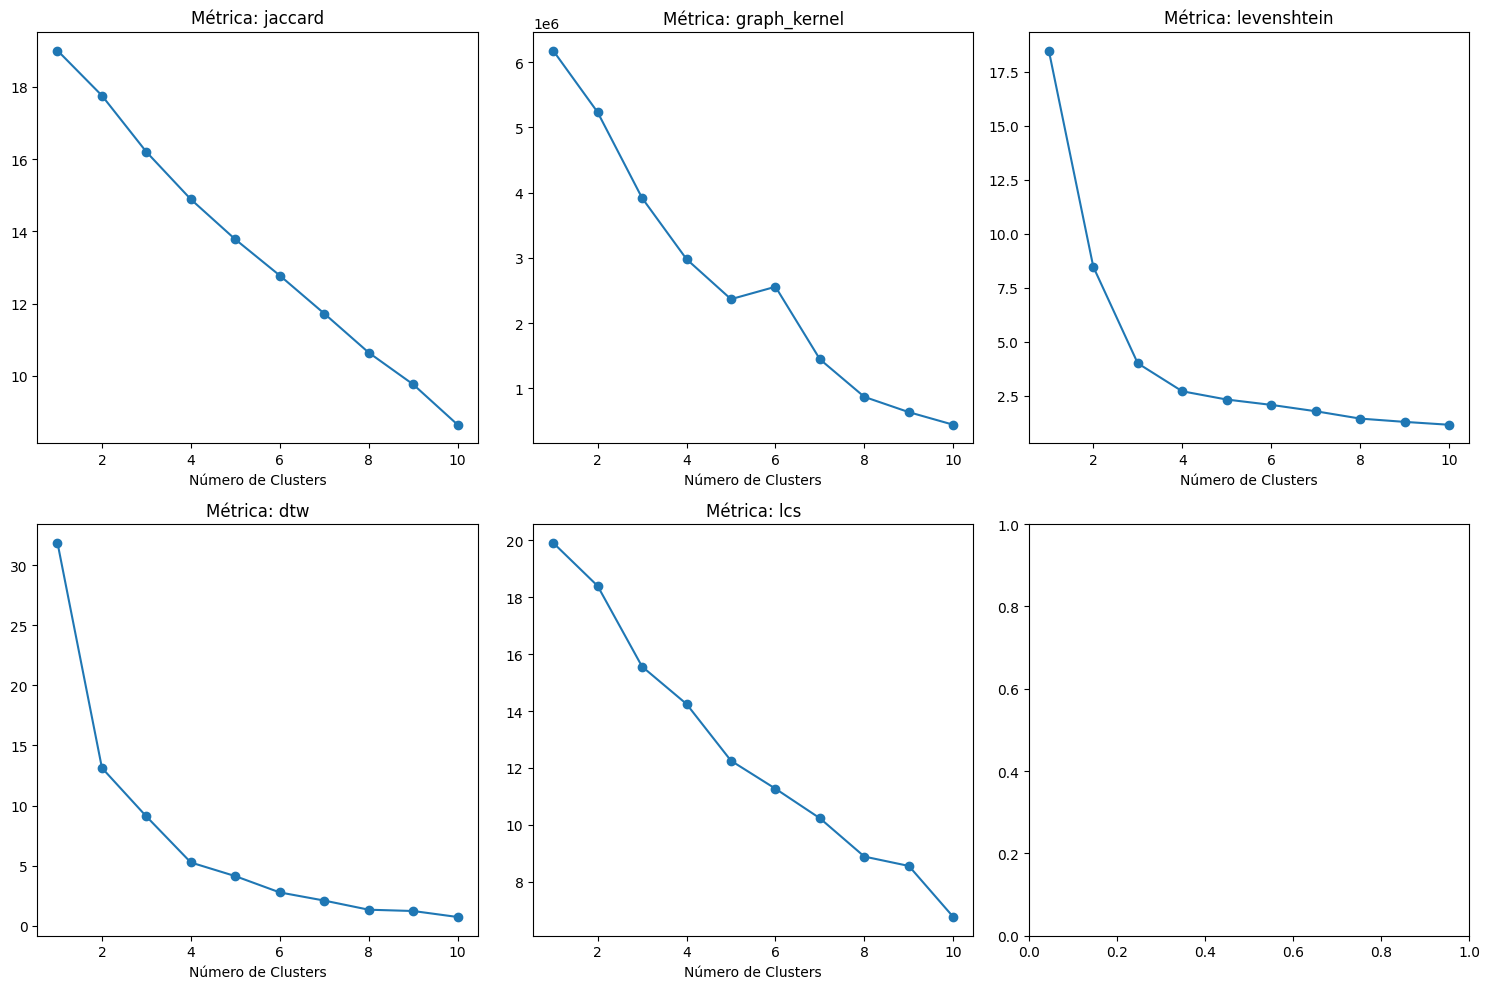

In [ ]:
metrics = ['jaccard', 'graph_kernel', 'subgraph_matching', 'distancia_edit', 'similarity', 'dtw', 'lcs', 'levenshtein'] # todas as metricas até o momento
teste = ['jaccard', 'graph_kernel', 'levenshtein', 'dtw', 'lcs']

graphs = build_graphs(df_gtfs)
elbow_method(graphs, similarity_metrics=teste)

## Gráficos e Mapas

### Salvando as labels com base nas observações do método do cotovelo

In [ ]:
# esse dict é preenchido na mão ao observar os gráficos
best_k_per_metric = {
    'jaccard': 3,
    'graph_kernel': 6,
    'levenshtein': 4,
    'dtw': 4,
    'lcs': 5,
}

In [57]:
def get_labels(df):
    # guarda as labels de cada metrica
    labels_dict = {}

    rota_ids = list(graphs.keys())

    for metric, k in best_k_per_metric.items():
        # Geração da matriz de distâncias
        X_sim = matriz_similaridade(graphs, medida_de_distancia=metric)
        
        # Clusterização
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_sim)
        
        labels_dict[metric] = kmeans.labels_

        # Mapear rótulos de grafos para pontos de ônibus
        rotulos_por_grafo = kmeans.labels_
        
        rota_para_cluster = {
            rota_ids[i]: rotulos_por_grafo[i]
            for i in range(len(rotulos_por_grafo))
        }

        df[f'cluster_{metric}'] = df['route_short_name'].map(rota_para_cluster)

    return labels_dict

In [34]:
def plot_clusters(df):
    num_metrics = len(best_k_per_metric)

    # Definindo o layout com base no número de métricas
    ncols = 3  # Escolha o número de colunas
    nrows = (num_metrics // ncols) + (num_metrics % ncols > 0)  # Calcula o número de linhas necessário

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 6 * nrows))

    # Se o número de subgráficos for menor que o número de células (quando nrows * ncols > num_metrics), remover os subgráficos extras
    axs = axs.flatten()
    for i in range(num_metrics, len(axs)):
        fig.delaxes(axs[i])

    # Plotando os gráficos
    for i, metric in enumerate(best_k_per_metric.keys()):
        axs[i].scatter(
            df['stop_lon'],
            df['stop_lat'],
            c=df[f'cluster_{metric}'],
            cmap='viridis',
            s=10
        )
        axs[i].set_title(f'Métrica: {metric}')
        axs[i].set_xlabel('Longitude')
        axs[i].set_ylabel('Latitude')
        axs[i].grid(True)

    plt.tight_layout()
    plt.suptitle('Clusterização de Pontos por Métrica de Similaridade entre Rotas', fontsize=16, y=1.05)
    plt.show()

### Imprimindo clusters por métrica de similaridade

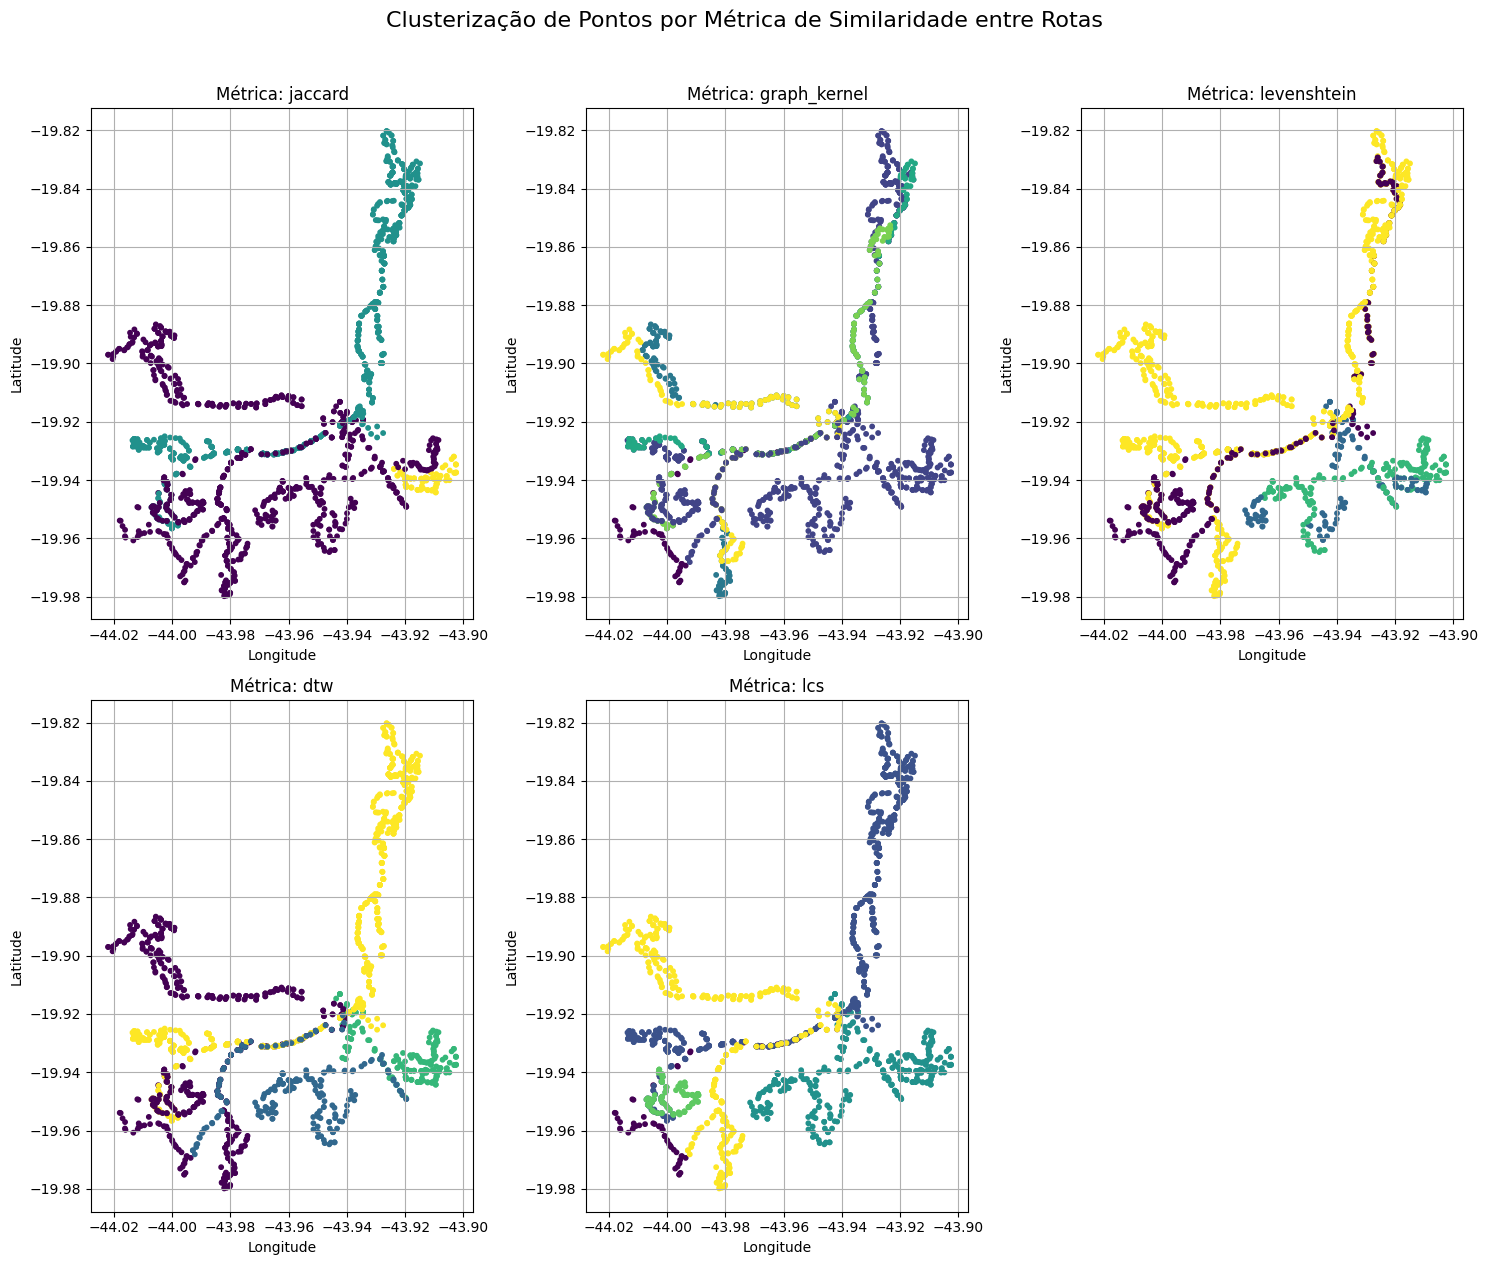

In [58]:
labels_dict = get_labels(df_gtfs)

plot_clusters(df_gtfs)

### Colorindo as rotas originais 

In [ ]:
def plot_original_routes(df):
    plt.figure(figsize=(8, 6))

    # Usar Seaborn para melhor paleta (ajuda com cores diferentes para muitas rotas)
    unique_routes = df['route_short_name'].unique()
    palette = sns.color_palette('hls', len(unique_routes))

    # Criar um dicionário que mapeia cada rota para um número (índice da paleta)
    rota_to_color = {rota: i for i, rota in enumerate(unique_routes)}

    # Mapear cada ponto para um número de cor com base na rota
    cores = df['route_short_name'].map(rota_to_color)

    # Plot
    plt.scatter(df['stop_lon'], df['stop_lat'], c=cores, cmap='tab20', s=10)
    plt.title('Pontos de Ônibus Coloridos por Rota')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

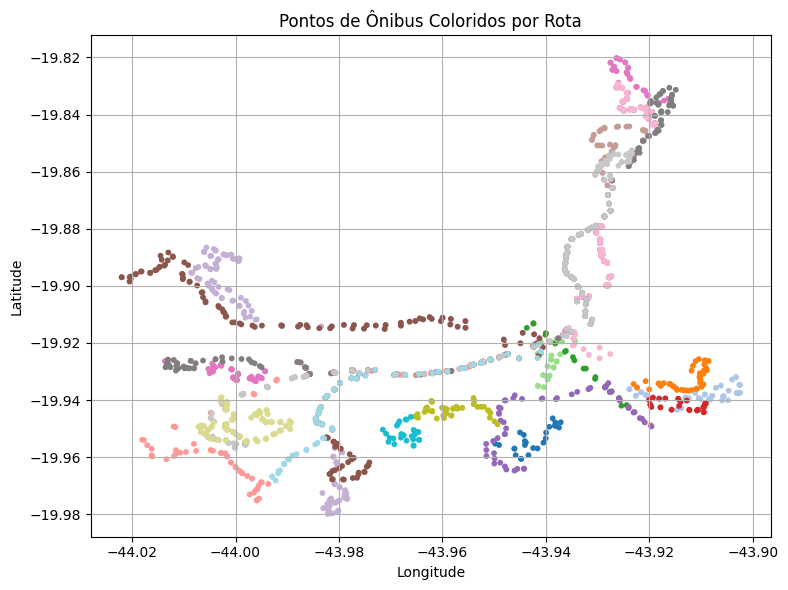

In [40]:
plot_original_routes(df_gtfs)

### Quantidade de rotas que passam por um ponto

In [ ]:
def plot_routes_per_stop(df):
    # Conta quantas rotas diferentes passam por cada ponto
    route_counts = df.groupby(['stop_lat', 'stop_lon'])['route_short_name'].nunique().reset_index(name='num_rotas')

    # Junta com as coordenadas para plotar
    df_merged = df.drop_duplicates(subset=['stop_lat', 'stop_lon']).merge(route_counts, on=['stop_lat', 'stop_lon'])

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(df_merged['stop_lon'], df_merged['stop_lat'], c=df_merged['num_rotas'], cmap='viridis', s=10)
    plt.colorbar(sc, label='Nº de Rotas que Passam pelo Ponto')
    plt.title('Pontos Coloridos pela Quantidade de Rotas que Atendem')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

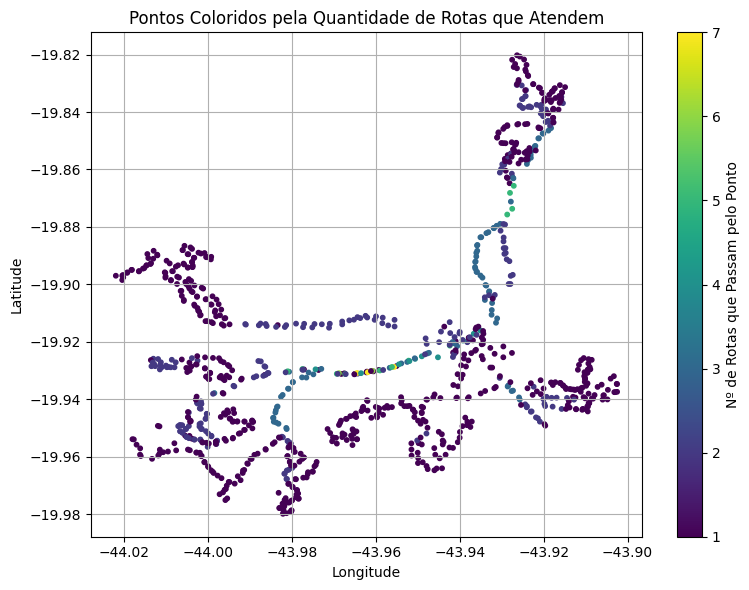

In [43]:
plot_routes_per_stop(df_gtfs)

## Avaliação

Usando:
* Silhouette
* Davies-Bouldin
* Calinski-Harabasz

In [60]:
avaliacoes = {}

for metric in labels_dict.keys():
    print(f"\n[{metric.upper()}] Avaliando clusters...")

    # Obter matriz de similaridade e converter para distância
    sim_matrix = matriz_similaridade(graphs, metric)
    dist_matrix = np.array(sim_matrix)
    
    # Reduzir dimensionalidade com MDS (posição vetorial dos grafos)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    X = mds.fit_transform(dist_matrix)

    labels = labels_dict[metric]

    silhouette = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)

    # 5. Salvar resultados
    avaliacoes[metric] = {
        'Silhouette': silhouette,
        'Davies-Bouldin': db,
        'Calinski-Harabasz': ch
    }



[JACCARD] Avaliando clusters...

[GRAPH_KERNEL] Avaliando clusters...

[LEVENSHTEIN] Avaliando clusters...

[DTW] Avaliando clusters...

[LCS] Avaliando clusters...


**Os valores ideais são:**

* Silhouette: quanto mais perto de 1, melhor.

* Davies-Bouldin: quanto menor, melhor.

* Calinski-Harabasz: quanto maior, melhor.

In [ ]:
avaliacoes_df = pd.DataFrame(avaliacoes).T
avaliacoes_df = avaliacoes_df.sort_values('Silhouette', ascending=False)
display(avaliacoes_df)

,Silhouette,Davies-Bouldin,Calinski-Harabasz
levenshtein,0.556940,0.531415,51.422137
dtw,0.395705,0.699814,23.093842
jaccard,-0.323170,58.655947,0.003858
graph_kernel,-0.431025,0.901959,4.443801
lcs,-0.459775,26.437542,0.008437
